# Frozen Lake

This project focuses on the development of RL agent that tries to find its way out of a frozen lake.

The environment on which the agent will take its decision is model as follow:

*  **Lake**: it is modeled as a matrix whose elements are Tile objects
*  **Tiles**: they build the Lake. They have different types, that will determine the reward the agent will recieve once it steps on them
    * **Frozen tile *F***: safe tile (Reward = -1)
    * **Hole tile *H***: dangerous tile (Reward = -100)
    * **Starting tile *S***: the agent starts its episode on this tile (Reward = -10)
    * **Exit tile *E***: once reached, the agent will be safe (10)

At each step, the agent will decide which action to take among the available ones. The default set of actions is **&#8592;**, **&#8593;**, **&#8594;** and **&#8595;**. If no tiles exist on a particular direction, then that action will not be available.

The layout of the lake is read from CSV file. The csv file needs to have its first element to be the starting tile *S* and the final one to be the exit tile "E".
Tiles different from F, H, S and E are not accepted.

The aim of this project is to understand the behaviour of the agent on changing learning parameters or policy algorithm. 

## Policy Iteration

For this first case, we will focus on solving the problem by appling the policy Evaluation-Improvement iteration:

The agent learns through different consecutive tries. Each iteration is composed by two steps:
1. **Policy Evaluation**: state value function is computed for all tiles on the basis of values and rewards the adjacent tiles.
2. **Policy Improvement**: for each tile the best action to take is determined by choosing the adjacent tile with the highest value

For this case we will consider a deterministic environment: taking action *a* at state *s* leads to state *s'* with *r* reward with unitary probability.

In [1]:
from utils import *
import time

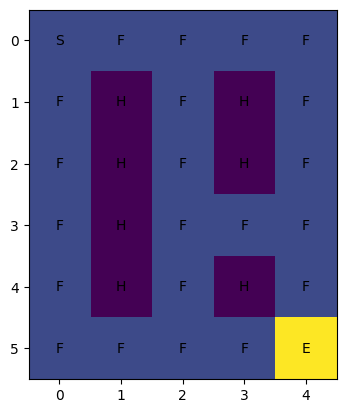

In [2]:
lake = Lake()
lake.ImportCSV('Lake.csv')
lake.Plot()

Let's initialize the lake environment:
For all initialization, the value of state function of each tile is computed by considering a uniform policy *&#960;*.
This means that all adjacent cells have the same probility of being chosen by the agent.

This will not be true after initialization: the agent will perform *greedy* choices, by stepping on the adjacent tile with the highest value of state function. 

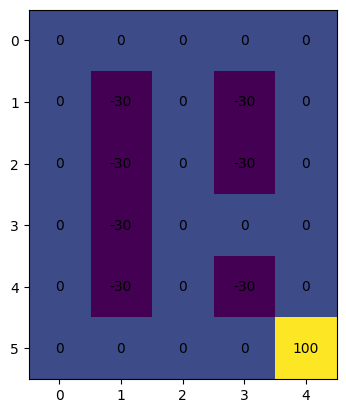

In [3]:
# Initalization
lake.Initialize()  

# Values of state value function after initialization
lake.PrintValues()      

Let's find the optimal policy for the current problem through policy iteration

Convergence reached
Time passed 0.0009764000001268869 seconds. 35 iterations


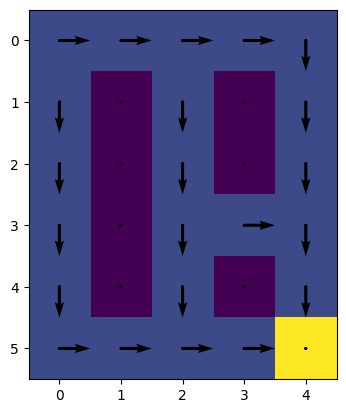

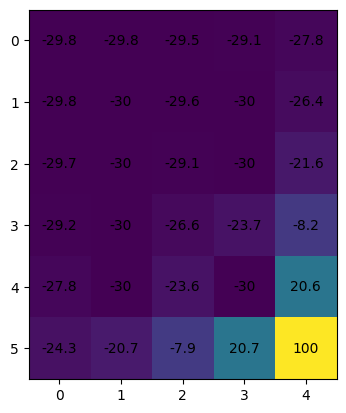

In [4]:
# policy iteration
iterations = 1000 # max number of iteration to reach convergence
delta = 0.001 # treshold value for error. Once a lower value is computed, the iteration ends
t = 0
gamma = 1

while (True):
    start = time.perf_counter()    
    # policy-evaluation:
    deltas = np.zeros(lake.shape)
    V = np.zeros(lake.shape)
    for i in range(lake.shape[0]):
        for j in range(lake.shape[1]):
            current_tile = lake.Grid[i][j]
            if (current_tile.Type in ['F','S']):
                neighbours = lake.GetNeighbours(current_tile)
                values = [n.value for n in neighbours]
                new_value = np.sum(values)/len(neighbours)
                deltas[i,j] = abs(new_value - current_tile.value)
                V[i,j] = new_value

    for i in range(lake.shape[0]):
        for j in range(lake.shape[1]):
            current_tile = lake.Grid[i][j]
            if (current_tile.Type in ['F','S']):
                lake.Grid[i][j].value = V[i,j]

    t+=1
    d = np.max(deltas)
    if (d<=delta):
        print(f'Convergence reached')
        break
    if (t >= iterations):
        print(f'Max number of iterations reached.')        
        break

# policy-improvement (Control)
for i in range(lake.shape[0]):
    for j in range(lake.shape[1]):
        current_tile = lake.Grid[i][j]
        if (current_tile.Type in ["F","S"]):
            neighbours = lake.GetNeighbours(current_tile)
            values = [neighbour.reward + gamma*neighbour.value for neighbour in neighbours]
            max_indexes = np.argwhere(values == np.max(values)).flatten().tolist()
            for index in max_indexes:
                lake.Grid[i][j].actions.append(Action(neighbours[index],current_tile))

end = time.perf_counter()
time_pi = end-start
print(f"Time passed {time_pi} seconds. {t} iterations")
lake.PrintActions()
lake.PrintValues()

## Value Iteration

For this case we will apply the **value iteration** algorithm to solve the problem.

This one is faster than the previous **policy iteration**, since it computes the values of the state function (*policy evaluation*) and the policy (*policy improvement*) in just one iteration. While, previously each step would require an individual iteration.

Convergence reached
Time passed 0.0007332000000133121 seconds. 10 iterations


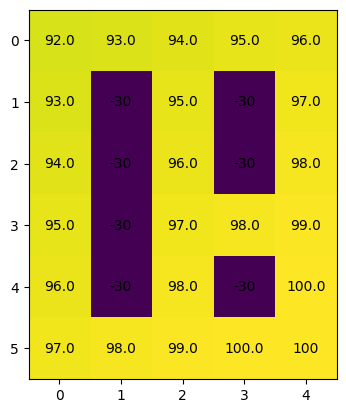

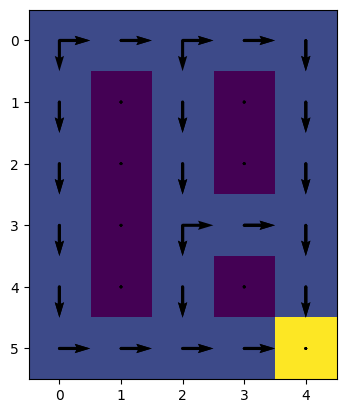

In [5]:
# value iterartion:
lake.Initialize()
iterations = 1000
delta = 0.001
t = 0
gamma = 1

while (True):
    start = time.perf_counter()
    deltas = np.zeros([lake.shape[0],lake.shape[1]])
    V = np.zeros(lake.shape)
    for i in range(lake.shape[0]):
        for j in range(lake.shape[1]):
            current_tile = lake.Grid[i][j]
            if (current_tile.Type in ["F","S"]):
                neighbours = lake.GetNeighbours(current_tile)
                values = []
                for neighbour in neighbours:
                    if (neighbour.Type in ['F','S']):
                        values.append(neighbour.reward + gamma*neighbour.value)
                    else:
                        values.append(neighbour.reward)
                                
                n_max = np.argmax(values)
                deltas[i,j] = abs(np.max(values) - lake.Grid[i][j].value)
                V[i,j] = np.max(values)
                
    for i in range(lake.shape[0]):
        for j in range(lake.shape[1]):
            current_tile = lake.Grid[i][j]
            if (current_tile.Type in ["F","S"]):
                lake.Grid[i][j].value = V[i,j]
    
    t+=1
    d = np.max(deltas)
    if (d<=delta):
        print(f'Convergence reached')
        break
    if (t >= iterations):
        print(f'Max number of iterations reached.')        
        break

for i in range(lake.shape[0]):
    for j in range(lake.shape[1]):
        current_tile = lake.Grid[i][j]
        if (current_tile.Type in ["F","S"]):
            neighbours = lake.GetNeighbours(current_tile)
            values = [n.reward + gamma*n.value for n in neighbours]
            max_indexes = np.argwhere(values == np.max(values)).flatten().tolist()
            for index in max_indexes:
                lake.Grid[i][j].actions.append(Action(neighbours[index],current_tile))
            
end = time.perf_counter()
time_vi = end-start
print(f"Time passed {time_vi} seconds. {t} iterations")
lake.PrintValues()
lake.PrintActions()

## Stochastic model

So far we have considered that the reward recieved is deterministic, therefore once the agent steps on a tile it will recieve always the same reward.
Let's imagine instead, that stepping on a tile that is surrounded by holes could be more dangerous than stepping on one that has safe tiles all around.

$ p(s', r_{\text{hole}} \mid s, r) = \frac{n_{\text{hole}}^{s'}}{4} $

To solve this problem we will use the *value-iteration* algorithm

Convergence reached
Time passed 0.001422899999852234 seconds. 10 iterations


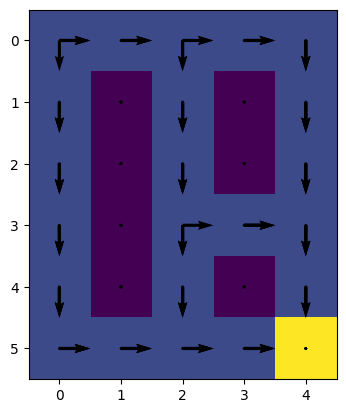

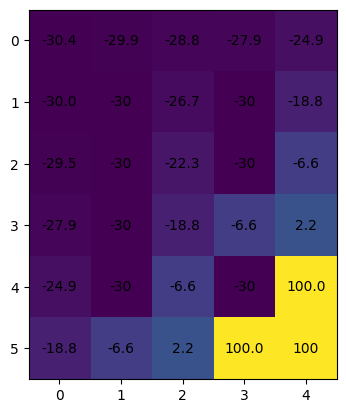

In [6]:
lake.Initialize()
lake.ValueIteration(1000,0.001,1,'stochastic')
lake.PrintActions()
lake.PrintValues()